# PumpItUp
## DrivenDataCompetition PumpItUp
- All data is within the same folder as notebook

In [42]:
import pandas as pd
import matplotlib as plt
import sklearn
import seaborn as sns
import numpy as np

In [36]:
# load training-data and labels
trainingValues = pd.read_csv('4910797b-ee55-40a7-8668-10efd5c1b960.csv')
trainingLabels = pd.read_csv('0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')
trainingData = pd.merge(trainingValues, trainingLabels, on= 'id')
trainingData.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


# Investigation and Cleansing of data
Possible data-issues
* population == 0 -> Maybe delete all lines with population?
* num_private Not in feature-description -> Maybe delete column?
* object-data needs to be converted in category-numbers
* idea: funders and installers who fund and install regularly are less porbable to create failing pumps than those who do it less often. Thererfore the names are exchanged with the number of occurances. Same for basin, wpt_name, subvillage, scheme_name and schmeme_management

In [37]:
def cleanData(data : pd.DataFrame, columns : list):
    #data = data[data.population != 0] # delete population == 0
    if 'num_private' in data.columns: # drop 'num_private'
        data = data.drop('num_private', axis = 1)
    
    data['public_meeting'] = data['public_meeting'].fillna('True') #fill nan with 'True'
    data['permit'] = data['permit'].fillna('True')
    
    for columnName in columns: # make all strings lower case and replace names with number of occurence.
        data[columnName] = data[columnName].fillna('unknown')
        data.loc[data[columnName].str.len() <=2, columnName] = 'unknown'
        data.loc[data[columnName] == 'none', columnName] = 'unknown'
        data[columnName].str.lower()
        data = data.replace({columnName : data[columnName].value_counts().to_dict()})
        
    #change data-recorded to year- and month-only-columns
    data['date_recorded'] = pd.to_datetime(data['date_recorded'], format='%Y-%m-%d')
    data['year_recorded'] =data['date_recorded'].dt.year
    data['month_recorded'] = data['date_recorded'].dt.month
        
    return data
    
def createCatColumnsWithCodes(data : pd.DataFrame):
    cat_columns = data.select_dtypes(['object']).columns
    if len(cat_columns) == 0:
        return data
    data[cat_columns] = data[cat_columns].astype('category')
    cat_data = data[cat_columns].apply(lambda x: x.cat.codes)
    data = data.join(cat_data, rsuffix='_cat')

    return data


# clean data
trainingData = cleanData(trainingData, ['funder', 'installer','wpt_name','basin', 'subvillage','scheme_name', 'scheme_management'])

#change labels to category data
trainingData = createCatColumnsWithCodes(trainingData)


In [38]:
trainingData.dtypes

id                                    int64
amount_tsh                          float64
date_recorded                datetime64[ns]
funder                                int64
gps_height                            int64
installer                             int64
longitude                           float64
latitude                            float64
wpt_name                              int64
basin                                 int64
subvillage                            int64
region                             category
region_code                           int64
district_code                         int64
lga                                category
ward                               category
population                            int64
public_meeting                     category
recorded_by                        category
scheme_management                     int64
scheme_name                           int64
permit                             category
construction_year               

In [39]:
# Show data-frame top
trainingData.head(100)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,...,water_quality_cat,quality_group_cat,quantity_cat,quantity_group_cat,source_cat,source_type_cat,source_class_cat,waterpoint_type_cat,waterpoint_type_group_cat,status_group_cat
0,69572,6000.0,2011-03-14,275,1390,94,34.938093,-9.856322e+00,3591,5085,...,6,2,1,1,8,6,0,1,1,0
1,8776,0.0,2013-03-06,53,1399,39,34.698766,-2.147466e+00,830,10248,...,6,2,2,2,5,3,1,1,1,0
2,34310,25.0,2013-02-25,8,686,408,37.460664,-3.821329e+00,3,8940,...,6,2,1,1,0,1,1,2,1,0
3,67743,0.0,2013-01-28,1057,263,222,38.486161,-1.115530e+01,1,4493,...,6,2,0,0,3,0,0,2,1,2
4,19728,0.0,2011-07-13,1,0,135,31.130847,-1.825359e+00,1748,10248,...,6,2,3,3,5,3,1,1,1,0
5,9944,20.0,2011-03-13,150,0,17402,39.172796,-4.765587e+00,1,8940,...,4,4,1,1,4,2,2,2,1,0
6,19816,0.0,2012-10-01,811,0,192,33.362410,-3.766365e+00,1,7785,...,6,2,1,1,3,0,0,4,3,2
7,54551,0.0,2012-10-09,1374,0,17402,32.620617,-4.226198e+00,4,6432,...,3,3,1,1,7,5,0,4,3,2
8,53934,0.0,2012-11-03,333,0,48,32.711100,-5.146712e+00,1,6432,...,4,4,3,3,3,0,0,4,3,2
9,46144,0.0,2011-08-03,14,0,135,30.626991,-1.257051e+00,1,10248,...,6,2,1,1,7,5,0,4,3,0


In [40]:
# Describe data
trainingData.describe()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,...,water_quality_cat,quality_group_cat,quantity_cat,quantity_group_cat,source_cat,source_type_cat,source_class_cat,waterpoint_type_cat,waterpoint_type_group_cat,status_group_cat
count,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,...,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,2713.594613,668.297239,6272.377104,34.077427,-5.706033e+00,297.992290,7381.297778,50.783569,...,5.754293,2.263047,1.325758,1.325758,6.063199,3.970556,0.233737,2.574091,2.056212,0.841162
std,21453.128371,2997.574558,3403.844820,693.116350,7524.365188,6.567432,2.946019e+00,891.671043,2057.020284,168.752916,...,0.900820,0.784268,0.803750,0.803750,2.034190,2.191798,0.434129,1.781438,1.378937,0.949794
min,0.000000,0.000000,1.000000,-90.000000,1.000000,0.000000,-1.164944e+01,1.000000,2454.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,155.000000,0.000000,138.000000,33.090347,-8.540621e+00,1.000000,5987.000000,2.000000,...,6.000000,2.000000,1.000000,1.000000,5.000000,3.000000,0.000000,1.000000,1.000000,0.000000
50%,37061.500000,0.000000,829.000000,369.000000,1050.000000,34.908743,-5.021597e+00,1.000000,7785.000000,5.000000,...,6.000000,2.000000,1.000000,1.000000,7.000000,5.000000,0.000000,2.000000,1.000000,0.000000
75%,55656.500000,20.000000,6836.000000,1319.250000,17402.000000,37.178387,-3.326156e+00,9.000000,8940.000000,13.000000,...,6.000000,2.000000,2.000000,2.000000,8.000000,6.000000,0.000000,4.000000,3.000000,2.000000
max,74247.000000,350000.000000,9084.000000,2770.000000,17402.000000,40.345193,-2.000000e-08,3591.000000,10248.000000,1098.000000,...,7.000000,5.000000,4.000000,4.000000,9.000000,6.000000,2.000000,6.000000,5.000000,2.000000


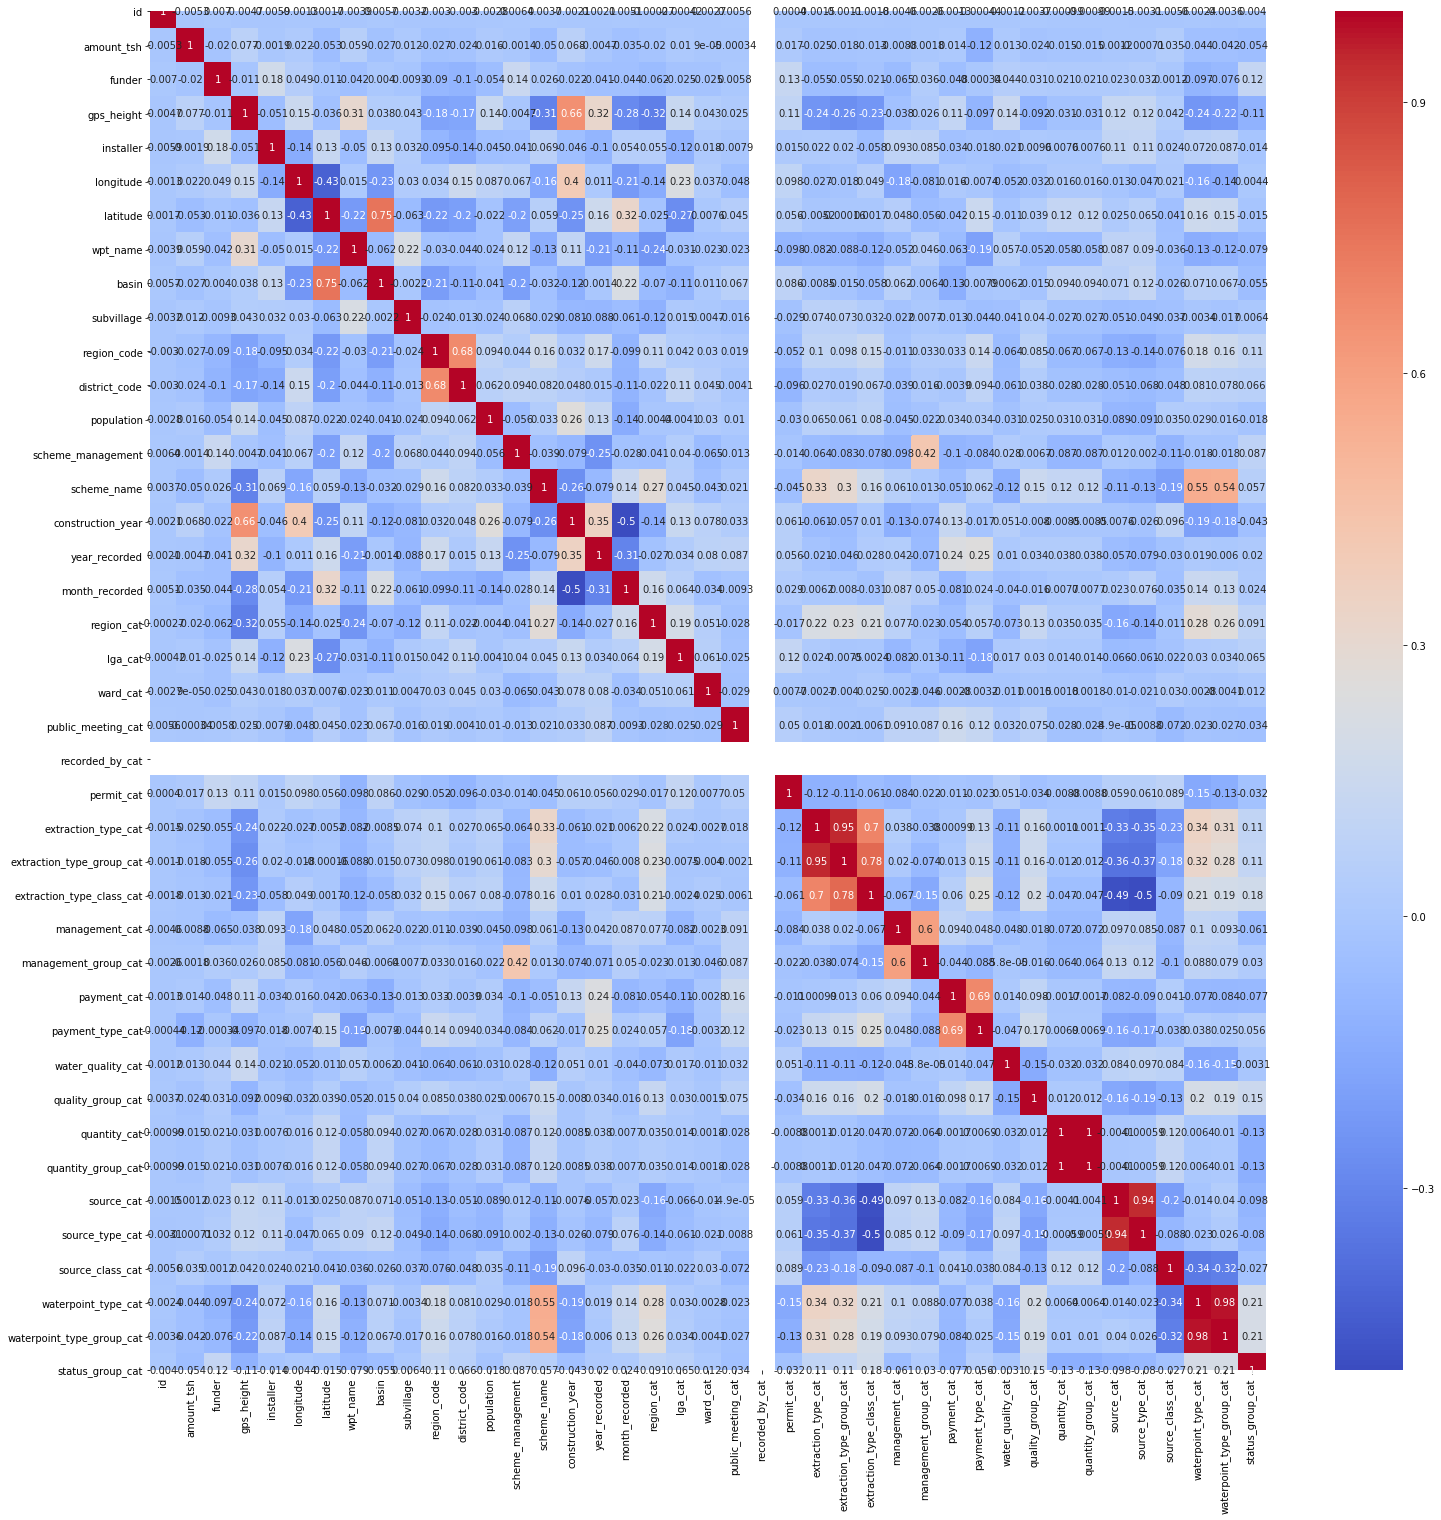

In [43]:
#check correlation
fig = plt.pyplot.gcf()
fig.set_size_inches(25,25)
sns.heatmap(trainingData.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')

In [44]:
from sklearn.model_selection import train_test_split

#split in labels and features
labels = trainingData['status_group_cat']
features = trainingData.drop(['status_group_cat','id'],axis=1)
no_use_columns = features.select_dtypes(['category']).columns
features = features.drop(no_use_columns, axis=1)
features_list = features.columns

#split labels and features is train-data and test-data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

#check shape
print('train_features: ', train_features.shape)
print('train_labels: ', train_labels.shape)
print('test_features: ', test_features.shape)
print('test_labels: ', test_labels.shape)

train_features:  (44550, 40)
train_labels:  (44550,)
test_features:  (14850, 40)
test_labels:  (14850,)


# Try random forest


In [15]:
## Try random fit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import pickle

##create random grid
# number of trees in forest
n_estimators = [int(x) for x in np.linspace(start = 1500, stop= 1900, num = 100)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 5, 6, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method for selecting samples for training each node
bootstrap = [True, False]
# max features
max_features = ['auto', 'log2', 'sqrt']

random_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_features': max_features,
              'bootstrap': bootstrap}

randomforest = RandomForestClassifier()

randomforest_random = RandomizedSearchCV(estimator = randomforest, param_distributions=random_grid, n_iter = 100, cv= None, verbose= 20, random_state= 42, n_jobs = -1)
randomforest_random.fit(features, labels)
best_estimator = randomforest_random.best_estimator_

# Show parameters
print('Best parameters: ',randomforest_random.best_params_)

# Show Accuracy
predictions = best_estimator.predict(test_features)
print ('Accuracy-Score of randomforest is: ', sklearn.metrics.accuracy_score(test_labels, predictions))




def competitionOutput(filenameIn: string, filenameOut : string ,estimator):
    # prepare competition features
    competition_features = pd.read_csv(filenameIn)
    competition_features_prepared = cleanData(competition_features, ['funder', 'installer','wpt_name','basin'])
    competition_features_prepared = createCatColumnsWithCodes(competition_features_prepared)
    competition_features_prepared = competition_features_prepared.drop(['id'],axis=1)
    no_use_columns = competition_features_prepared.select_dtypes(['category']).columns
    competition_features_prepared = competition_features_prepared.drop(no_use_columns, axis=1)

    predictions = estimator.predict(competition_features_prepared)
    competition_result = pd.read_csv(filenameIn)
    competition_result['status_group'] = predictions
    competition_result = competition_result[['id', 'status_group']]
    competition_result['status_group'] = competition_result['status_group'].replace([0,1,2],['functional','functional needs repair', 'non functional'])

    #create output csv
    competition_result.to_csv(filenameOut, index=False)
    return

competitionOutput('702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv', 'predictionsV3.csv', best_estimator)


#store parameters in pkl-file
file = open('parameters.pkl', 'wb')
pickle.dump(randomforest_random.best_params_, file)
predictions = best_estimator.predict(test_features)
file.close()

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
